In [36]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [37]:
dataset = './keypoint.csv'
model_save_path = './keypoint_classifier.hdf5'
tflite_save_path = './keypoint_classifier.tflite'

# Set number of classes

In [38]:
NUM_CLASSES = 4

# Dataset reading

In [39]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [40]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [43]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 40)                1720      
                                                                 
 dense_7 (Dense)             (None, 10)                410       
                                                                 
 dense_8 (Dense)             (None, 4)                 44        
                                                                 
Total params: 2,174
Trainable params: 2,174
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [45]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [46]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


1/6 [====>.........................] - ETA: 2s - loss: 1.4627 - accuracy: 0.2578
Epoch 1: saving model to .\keypoint_classifier.hdf5
6/6 [==============================] - 1s 55ms/step - loss: 1.4041 - accuracy: 0.2609 - val_loss: 1.3031 - val_accuracy: 0.3004
Epoch 2/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.3387 - accuracy: 0.2422
Epoch 2: saving model to .\keypoint_classifier.hdf5
6/6 [==============================] - 0s 14ms/step - loss: 1.2926 - accuracy: 0.3433 - val_loss: 1.2165 - val_accuracy: 0.5202
Epoch 3/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.2639 - accuracy: 0.4375
Epoch 3: saving model to .\keypoint_classifier.hdf5
6/6 [==============================] - 0s 15ms/step - loss: 1.2057 - accuracy: 0.5007 - val_loss: 1.1435 - val_accuracy: 0.6682
Epoch 4/1000
1/6 [====>.........................] - ETA: 0s - loss: 1.1471 - accuracy: 0.6172
Epoch 4: saving model to .\keypoint_classifier.hdf5
6/6 [==============================] - 0s 16m

In [58]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 0.0625 - accuracy: 0.9910


In [59]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [49]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 76ms/step
[8.6180840e-08 9.9999917e-01 3.6424234e-19 6.6980010e-07]
1


# Confusion matrix

7/7 [==============================] - 0s 2ms/step


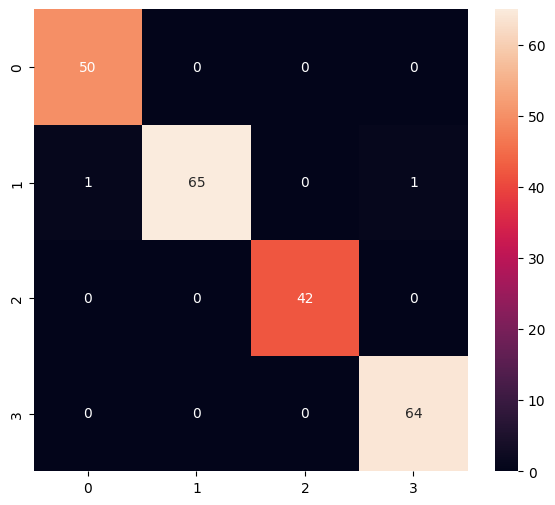

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.97      0.98        67
           2       1.00      1.00      1.00        42
           3       0.98      1.00      0.99        64

    accuracy                           0.99       223
   macro avg       0.99      0.99      0.99       223
weighted avg       0.99      0.99      0.99       223



In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [51]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [52]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\moham\AppData\Local\Temp\tmp2pl5tyxj\assets


INFO:tensorflow:Assets written to: C:\Users\moham\AppData\Local\Temp\tmp2pl5tyxj\assets


5872

# Inference test

In [53]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [54]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [55]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [56]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [57]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.6677154e-08 9.9999928e-01 3.7176237e-19 6.0670078e-07]
1
